In [1]:
import matplotlib.pyplot as plt

import re, os, time, random
import pandas as pd
import numpy as np

import seaborn as sns
sns.set(style="darkgrid")

import tensorflow as tf
import pickle as pkl

from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.models import model_from_json
from keras.models import Model, load_model
from keras.layers import LSTM, GRU, Input, Dense, Embedding
from keras.preprocessing.sequence import pad_sequences

from prettytable import PrettyTable
from nltk.translate.bleu_score import sentence_bleu

In [2]:
SEED = 1337

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Подготовка даных

In [3]:
def preprocess_sentence(data, punctuation=False, add_tokens=False):
    """
        Функция для предобработки 
    """
    
    # Уменьшаем регистр и убираем лишние пробелы
    data = [w.lower().strip() for w in data]
    
    # Замена всех символов 'æ' на однотипный
    data = [re.sub(r"ӕ", r"æ", w) for w in data]
    
    # Удаление апострофом
    data = [re.sub("'", '', w) for w in data]
    
    if punctuation:
        # Делаем между словом и знаком пунктуации отступ 'слово! -> слово !'
        data = [re.sub(r"([?.!,])", r" \1 ", w) for w in data]
        data = [re.sub(r'[" "]+', " ", w) for w in data]
    else:
        # Удаляет все знаки пунктуации
        data = [re.sub(r"[^\w\s]", r"", w) for w in data]
    
    # Выкидываем все остальные символы из рассмотрения 
    data = [re.sub(r"[^a-яА-Яa-zA-Z?.!,æё]+", " ", w) for w in data]
    data = [w.rstrip().strip() for w in data]
    
    # Добавляем токены для начала и конца предложения
    if add_tokens:
        data = [f'{start_target} {w} {end_target}' for w in data]
        
    return data

In [4]:
def read_dataset(path, preparing=False):
    """
        Функция для создания датасета
    """
    
    # Открытие файла с данными в кодировке UTF-8
    with open(path, encoding='utf-8') as f:
        data = f.read()
    
    # Разделение данных на пары <<предложение, перевод>>
    uncleaned_data_list = data.split('\n')
    
    source_word = []
    target_word = []
    for word in uncleaned_data_list:
        source_word.append(word.split('\t')[0])
        target_word.append(word.split('\t')[1])
    
    # Инецализация датафрейма pandas
    language_data = pd.DataFrame(columns=['Source','Target'])
    if preparing:
        language_data['Source'] = preprocess_sentence(source_word)
        language_data['Target'] = preprocess_sentence(target_word, add_tokens=True)
    else:
        language_data['Source'] = source_word
        language_data['Target'] = target_word
        
    return language_data

In [5]:
def tokenize(text_data):
    '''
        Токенайзер
    '''
    
    tokenizer = Tokenizer(filters='"#$%&()*+-/:;=@[\\]^_`{|}~\t\n')
    tokenizer.fit_on_texts(text_data)
    return tokenizer

In [6]:
def preparing_data(path):
    '''
        Подготовка данных и инициализации переменных для модели
    '''
    data = read_dataset(path, preparing=True)
    tokenizer_input, tokenizer_output = tokenize(data['Source'].values), tokenize(data['Target'].values)
    input_max_length = len(tokenizer_input.word_index) + 1
    output_max_length = len(tokenizer_output.word_index) + 1
    
    return data, tokenizer_input, tokenizer_output, input_max_length, output_max_length

In [7]:
def show_plot():
    '''
        Отрисовка графика потерь и точности
    '''
    plt.figure(figsize=(20,8), dpi= 80)
    plt.plot(graph.history['loss'], label='Training loss')
    plt.plot(graph.history['accuracy'], label='Training Accuracy')
    
    plt.legend()
    plt.show()

# Построение модели Encoder-Decoder

In [8]:
class Encoder(tf.keras.Model):
    """
        Энкодер 
    """
    
    def __init__(self, vocab_size_input, HIDDEN_DIM):
        super(Encoder, self).__init__()
        
        self.inputs = Input(shape=(None,), name="encoder_inputs")
        self.embedding = Embedding(vocab_size_input, HIDDEN_DIM, mask_zero=True, name="encoder_embedding")(self.inputs)
        
        self.encoder = LSTM(HIDDEN_DIM, return_state=True, name="encoder_lstm")
        self.outputs, state_h, state_c = self.encoder(self.embedding)
        self.states = [state_h, state_c]
    
    @staticmethod
    def getModel(model):
        inputs_inf = model.input[0]
        outputs_inf, inf_state_h, inf_state_c = model.layers[4].output
        inf_states = [inf_state_h, inf_state_c]
        
        return Model(inputs_inf, inf_states, name='Encoder') 

In [9]:
class Decoder(tf.keras.Model):
    """
        Декодер 
    """
    
    def __init__(self, vocab_size_output, HIDDEN_DIM, encoder_states):
        super(Decoder, self).__init__()

        self.inputs = Input(shape=(None,), name="decoder_inputs")
        self.embedding = Embedding(vocab_size_output, HIDDEN_DIM, mask_zero=True, name="decoder_embedding")(self.inputs)
        
        self.decoder = LSTM(HIDDEN_DIM, return_sequences=True, return_state=True, name="decoder_lstm")
        self.outputs, _, _ = self.decoder(self.embedding, initial_state=encoder_states)
        self.dense = Dense(vocab_size_output, activation='softmax', name="dense_lstm")
        self.outputs = self.dense(self.outputs)
    
    @staticmethod
    def getModel(model):
        state_h_input = Input(shape=(HIDDEN_DIM,))
        state_c_input = Input(shape=(HIDDEN_DIM,))
        state_input = [state_h_input, state_c_input]

        input_inf = model.input[1]
        emb_inf = model.layers[3](input_inf)
        lstm_inf = model.layers[5]
        output_inf, state_h_inf, state_c_inf = lstm_inf(emb_inf, initial_state=state_input)
        state_inf = [state_h_inf, state_c_inf]
        dense_inf = model.layers[6]
        output_final = dense_inf(output_inf)

        return Model([input_inf]+state_input, [output_final]+state_inf, name='Decoder')

In [10]:
def generator_batch(X, Y, batch_size):
    '''
        Генерация батчей
    '''
    max_length = lambda data: max([len(x.split(' ')) for x in data])
    
    while True:
        for j in range(0, len(X), batch_size):
            encoder_data_input   = np.zeros((batch_size, max_length(X)), dtype='float32')
            decoder_data_input   = np.zeros((batch_size, max_length(Y)), dtype='float32')
            decoder_target_input = np.zeros((batch_size, max_length(Y), vocab_size_target), dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j : j + batch_size], Y[ j : j + batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_data_input[i, t] = tokenizer_input.word_index[word]
                for t, word in enumerate(target_text.split()):
                    decoder_data_input[i, t] = tokenizer_output.word_index[word]
                    if t>0:
                        decoder_target_input[i,t - 1,tokenizer_output.word_index[word]] = 1
            yield ([encoder_data_input, decoder_data_input], decoder_target_input)

# Входные параметры

In [11]:
path = 'Date/rus-oss.txt'

start_target = "<sos>"
end_target = "<eos>"

HIDDEN_DIM = 256
batch_size = 6
epochs = 20

In [12]:
read_dataset(path).head()

,Source,Target
0,Чего ты смеёшься?,Цæуыл худыс?
1,Этот нож очень острый.,Ацы кард тынг цыргъ у.
2,У кошки девять жизней.,Гæдыйæн фараст царды ис.
3,Сегодня облачно.,Абон у асæст.
4,Он был вождём своего племени 35 лет.,Уый йæ знæмы раздзог уыдис 35 азы дæргъы.


In [13]:
data, tokenizer_input, tokenizer_output, vocab_size_source, vocab_size_target = preparing_data(path)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(data['Source'].values, data['Target'].values, test_size = 0.1)

In [15]:
data.head()

,Source,Target
0,чего ты смеёшься,<sos> цæуыл худыс <eos>
1,этот нож очень острый,<sos> ацы кард тынг цыргъ у <eos>
2,у кошки девять жизней,<sos> гæдыйæн фараст царды ис <eos>
3,сегодня облачно,<sos> абон у асæст <eos>
4,он был вождём своего племени лет,<sos> уый йæ знæмы раздзог уыдис азы дæргъы <eos>


In [16]:
print(f'Тренировочная выборка: {len(X_train)}')
print(f'Тестовая выборка: {len(X_test)}')

Тренировочная выборка: 423
Тестовая выборка: 47


In [17]:
encoder = Encoder(vocab_size_source, HIDDEN_DIM)
decoder = Decoder(vocab_size_target, HIDDEN_DIM, encoder.states)

In [18]:
model = Model([encoder.inputs, decoder.inputs], decoder.outputs, name="Seq2Seq-LSTM-Translation")

In [19]:
loss_function = 'categorical_crossentropy'
model.compile(loss=loss_function, optimizer='adam', metrics=['accuracy'])

# Обучение модели

In [20]:
# %%capture
graph = model.fit(generator_batch(X_train, y_train, batch_size=batch_size), steps_per_epoch=len(X_train)//batch_size, epochs=epochs)

Epoch 1/20
70/70 [==============================] - 10s 56ms/step - loss: 1.3115 - accuracy: 0.1532
Epoch 2/20
70/70 [==============================] - 4s 56ms/step - loss: 1.1498 - accuracy: 0.1679
Epoch 3/20
70/70 [==============================] - 4s 54ms/step - loss: 1.1047 - accuracy: 0.1737
Epoch 4/20
70/70 [==============================] - 4s 54ms/step - loss: 1.0436 - accuracy: 0.1788
Epoch 5/20
70/70 [==============================] - 4s 53ms/step - loss: 0.9952 - accuracy: 0.1854
Epoch 6/20
70/70 [==============================] - 4s 53ms/step - loss: 0.9445 - accuracy: 0.1907
Epoch 7/20
70/70 [==============================] - 4s 52ms/step - loss: 0.8856 - accuracy: 0.1985
Epoch 8/20
70/70 [==============================] - 4s 51ms/step - loss: 0.8425 - accuracy: 0.2107
Epoch 9/20
70/70 [==============================] - 4s 51ms/step - loss: 0.7967 - accuracy: 0.2259
Epoch 10/20
70/70 [==============================] - 4s 51ms/step - loss: 0.7410 - accuracy: 0.2452
Epoch 11

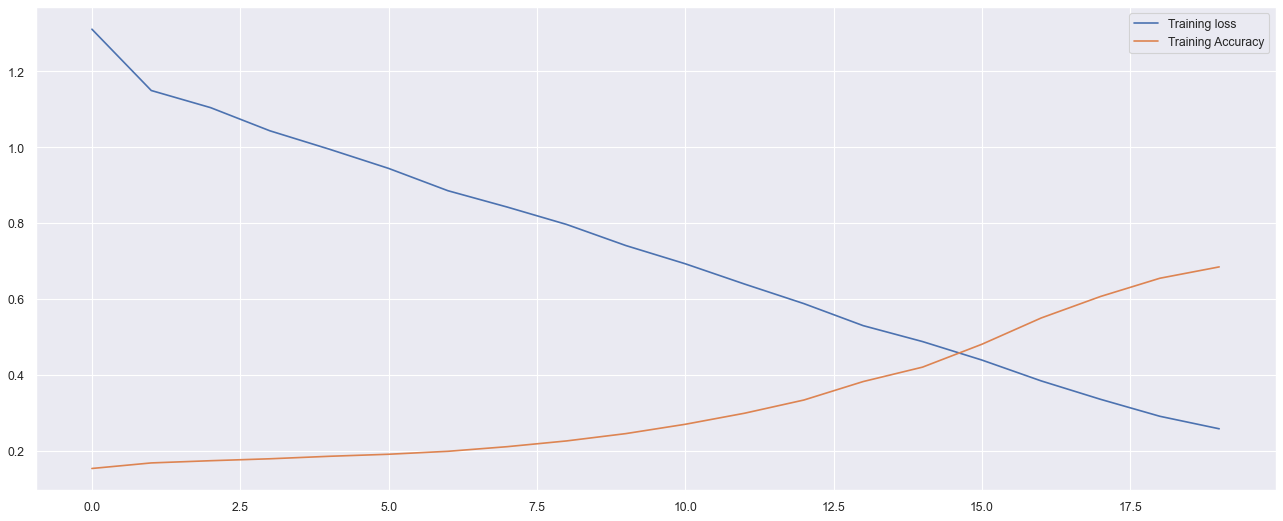

In [21]:
show_plot()

# Предсказание

In [22]:
def predict(input_seq, encoder_model, decoder_model, tokenizer_output, reverse_word_map_target):
    state_values_encoder = encoder_model.predict(input_seq)
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tokenizer_output.word_index[start_target]
    stop_condition = False
    decoder_sentance = ''
    
    while not stop_condition:
        sample_word , decoder_h, decoder_c= decoder_model.predict([target_seq] + state_values_encoder)
        sample_word_index = np.argmax(sample_word[0,-1,:])
        decoder_word = reverse_word_map_target[sample_word_index]
        decoder_sentance += ' ' + decoder_word
        if (decoder_word == end_target or 
            len(decoder_sentance) > 70):
            stop_condition = True
        target_seq[0, 0] = sample_word_index
        state_values_encoder = [decoder_h,decoder_c]
    return decoder_sentance

# Тесты

In [23]:
encoder_model = Encoder.getModel(model)
decoder_model = Decoder.getModel(model)

In [24]:
reverse_word_map_input  = dict(map(reversed, tokenizer_input.word_index.items()))
reverse_word_map_target = dict(map(reversed, tokenizer_output.word_index.items()))

In [25]:
for i in range(10):
    sentance = X_train[i]
    original_target = y_train[i]
    input_seq = tokenizer_input.texts_to_sequences([sentance])
    pad_sequence = pad_sequences(input_seq, maxlen=30, padding='post')
    predicted_target = predict(pad_sequence, encoder_model, decoder_model, tokenizer_output, reverse_word_map_target)
    reference = original_target[5:-5].strip().split()
    hypothetic = predicted_target[:-5].strip().split()
    
    print(f'Test #{i + 1}')
    table = pd.Series([sentance, 
                       original_target[5:-5].strip(), 
                       predicted_target[:-5].strip(), 
                       "%.3f" % sentence_bleu([hypothetic], reference, weights = [1])], 
                          index=['Sentance','Original','Predicted', 'BLEU'])
    
    print(table.to_string())
    print("==" * 50)

Test #1
Sentance     здесь не бываю
Original       ам нæ вæййын
Predicted       ам нæ æхсæз
BLEU                  0.667
Test #2
Sentance     хорошо
Original       хорз
Predicted      хорз
BLEU          1.000
Test #3
Sentance        ктото позвонил
Original     чидæр æрбадзырдта
Predicted    чидæр æрбадзырдта
BLEU                     1.000
Test #4
Sentance       кто в этом году идет в школу
Original         ацы аз скъоламæ чи цæудзæн
Predicted    ацы аз скъоламæ ацæмæз цæудзæн
BLEU                                  0.800
Test #5
Sentance            где ты отдыхал
Original     дæ фæллад кæм уагътай
Predicted               кæм вæййыс
BLEU                         0.250
Test #6
Sentance       кот
Original      гæды
Predicted    кæсын
BLEU         0.000
Test #7
Sentance        у меня нет денег но есть мечты
Original     æхца мæм нæй фæлæ мæм ис бæллицтæ
Predicted                æхца мæм нæй фæлæ мæм
BLEU                                     0.714
Test #8
Sentance     счастье вашему дому
Origina

In [26]:
for i in range(10):
    sentance = X_test[i]
    original_target = y_test[i]
    input_seq = tokenizer_input.texts_to_sequences([sentance])
    pad_sequence = pad_sequences(input_seq, maxlen= 30, padding='post')
    predicted_target = predict(pad_sequence, encoder_model, decoder_model, tokenizer_output, reverse_word_map_target)
    reference = original_target[5:-5].strip().split()
    hypothetic = predicted_target[:-5].strip().split()
    
    print(f'Test #{i + 1}')
    table = pd.Series([sentance, 
                       original_target[5:-5].strip(), 
                       predicted_target[:-5].strip(), 
                       "%.3f" % sentence_bleu([hypothetic], reference, weights = [1])], 
                          index=['Sentance','Original','Predicted', 'BLEU'])
    
    print(table.to_string())
    print("==" * 50)

Test #1
Sentance              нет я работал у меня отпуск будет зимой
Original     нæ кусгæ кæнын мæнæн ме нцойуагъд зымæджы уыдзæн
Predicted                           æз ам никуы нæ бавнæлдтон
BLEU                                                    0.125
Test #2
Sentance     расскажите нам всё что знаете
Original     радзурут нын алцыдæр цы зонут
Predicted                    ацы аз цы дыл
BLEU                                 0.200
Test #3
Sentance     у нас возле дома есть автобусная остановка
Original            нæ хæдзары цур ис автобусы æрлæууæн
Predicted                  мæнмæ ис æрмæстæр дæс чиныгы
BLEU                                              0.167
Test #4
Sentance               он его нашёл
Original             уый йæ ссардта
Predicted    уый кудзæй тæрскæ кода
BLEU                          0.239
Test #5
Sentance        мои уши красные
Original     мæ хъустæ сырx сты
Predicted       фараст царды ис
BLEU                      0.000
Test #6
Sentance        том ест корм для кош

# Сохранение

In [27]:
def save_tokenizers(path, tokenizer_input, tokenizer_output):
    with open(f'{path[5:-4]}-tokenizer_input.pkl','wb') as f:
        pkl.dump(tokenizer_input, f)

    with open(f'{path[5:-4]}-tokenizer_output.pkl','wb') as f:
        pkl.dump(tokenizer_output, f)

    pkl.dump(tokenizer_input, open(f'{path[5:-4]}-tokenizer_input.pkl', 'wb'))
    pkl.dump(tokenizer_output, open(f'{path[5:-4]}-tokenizer_output.pkl', 'wb'))

In [28]:
def save_model_and_weights(model):
    model_json = model.to_json()
    
    with open(f'LSTM-[{path[5:-4]}]-[Epochs={epochs}]-[LossFunction={loss_function}].json', "w") as json_file:
        json_file.write(model_json)
    
    model.save_weights(f'LSTM-[{path[5:-4]}]-[Epochs={epochs}]-[LossFunction={loss_function}]-[weight].h5')

In [29]:
save_tokenizers(path, tokenizer_input, tokenizer_output)
save_model_and_weights(model)

# Загрузка и проверка

In [30]:
def load_model_and_weights():
    json_file = open(f'LSTM-[{path[5:-4]}]-[Epochs={epochs}]-[LossFunction={loss_function}].json')
    loaded_model_json = json_file.read()
    json_file.close()
    model_loaded = model_from_json(loaded_model_json)

    model_loaded.load_weights(f'LSTM-[{path[5:-4]}]-[Epochs={epochs}]-[LossFunction={loss_function}]-[weight].h5')
    
    return model_loaded

In [31]:
def load_tokenizers():
    with open(f'{path[5:-4]}-tokenizer_input.pkl','rb') as f:
        tokenizer_input = pkl.load(f)
    with open(f'{path[5:-4]}-tokenizer_output.pkl','rb') as f:
        tokenizer_output = pkl.load(f)

    return tokenizer_input, tokenizer_output

In [32]:
model_load = load_model_and_weights()
tokenizer_input_load, tokenizer_output_load = load_tokenizers()

In [33]:
encoder_model_load = Encoder.getModel(model_load)
decoder_model_load = Decoder.getModel(model_load)

In [34]:
reverse_word_map_input  = dict(map(reversed, tokenizer_input_load.word_index.items()))
reverse_word_map_target = dict(map(reversed, tokenizer_output_load.word_index.items()))

In [35]:
for i in range(4):
    sentance = X_test[i]
    original_target = y_test[i]
    input_seq = tokenizer_input.texts_to_sequences([sentance])
    pad_sequence = pad_sequences(input_seq, maxlen=30, padding='post')
    predicted_target = predict(pad_sequence, encoder_model_load, decoder_model_load, tokenizer_output_load, reverse_word_map_target)
    reference = original_target[5:-5].strip().split()
    hypothetic = predicted_target[:-5].strip().split()
    
    print(f'Test #{i + 1}')
    table = pd.Series([sentance, 
                       original_target[5:-5].strip(), 
                       predicted_target[:-5].strip(), 
                       "%.3f" % sentence_bleu([hypothetic], reference, weights = [1])], 
                          index=['Sentance','Original','Predicted', 'BLEU'])
    
    print(table.to_string())
    print("==" * 50)

Test #1
Sentance              нет я работал у меня отпуск будет зимой
Original     нæ кусгæ кæнын мæнæн ме нцойуагъд зымæджы уыдзæн
Predicted                           æз ам никуы нæ бавнæлдтон
BLEU                                                    0.125
Test #2
Sentance     расскажите нам всё что знаете
Original     радзурут нын алцыдæр цы зонут
Predicted                    ацы аз цы дыл
BLEU                                 0.200
Test #3
Sentance     у нас возле дома есть автобусная остановка
Original            нæ хæдзары цур ис автобусы æрлæууæн
Predicted                  мæнмæ ис æрмæстæр дæс чиныгы
BLEU                                              0.167
Test #4
Sentance               он его нашёл
Original             уый йæ ссардта
Predicted    уый кудзæй тæрскæ кода
BLEU                          0.239
